In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
import math as math

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
y_train = train.y
X_train = train.drop(columns=['y', 'id'])

# EDA

# Look at output of y to see if transformation is appropriate 

<AxesSubplot:xlabel='y', ylabel='Density'>

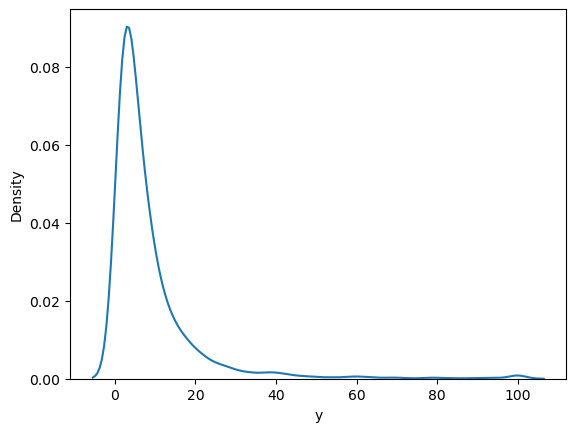

In [3]:
sns.kdeplot(data=y_train)

we see it is very skewed, try log transformation

<AxesSubplot:xlabel='y', ylabel='Density'>

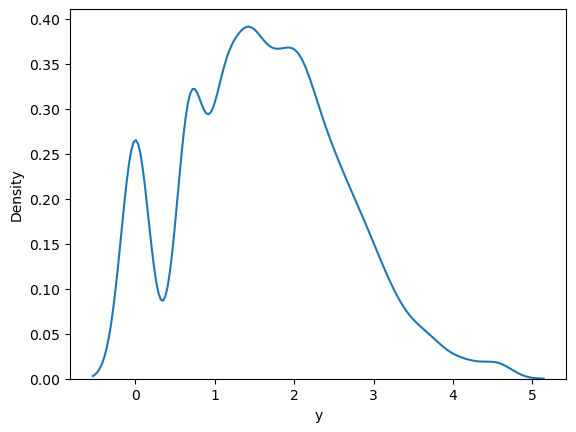

In [4]:
sns.kdeplot(data=np.log(y_train))

other possible transformations

<AxesSubplot:xlabel='y', ylabel='Density'>

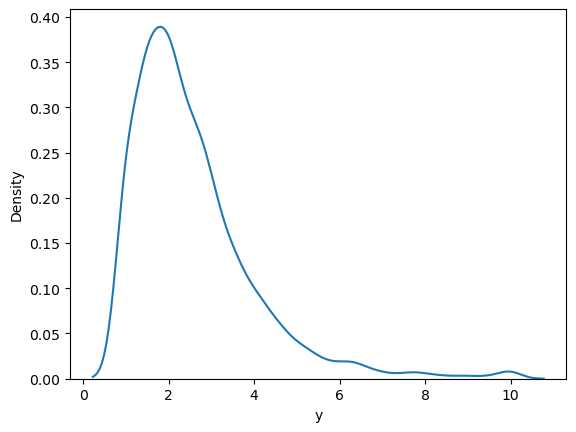

In [5]:
sns.kdeplot(data=np.sqrt(y_train))

binning?

In [6]:
bins, counts = pd.cut(np.square(y_train), 2, retbins=True)
counts = np.array(counts)
print(bins.value_counts())

(-8.999, 5000.5]     5332
(5000.5, 10000.0]      48
Name: y, dtype: int64


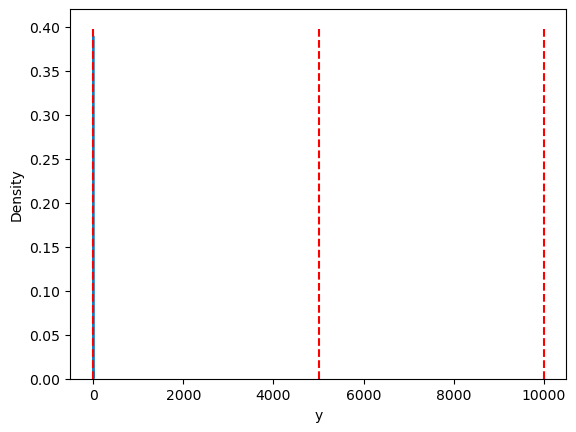

In [7]:
sns.kdeplot(np.sqrt(y_train))
plt.vlines(x=counts, ymin=0, ymax=.4, colors='red', linestyles='--')
plt.show()

In [8]:
min(y_train)

1

binning doesn't seem to make sense

### *Best transformation = SQRT even though still a bit skewed, it is the most normal*

# look at x train dataset

In [9]:
print("shape:", X_train.shape)

shape: (5380, 765)


In [10]:
cor_lst = np.abs(X_train.corrwith(y_train)).sort_values(ascending=False)
cor_lst

x146    0.378696
x102    0.378436
x014    0.364737
x581    0.346549
x619    0.344101
          ...   
x465         NaN
x518         NaN
x594         NaN
x643         NaN
x703         NaN
Length: 754, dtype: float64

In [11]:
cor_lst[cor_lst.isna()]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

Lots of the correlation coefs are Nan - why?

In [12]:
X_train.x063.value_counts()

0    5380
Name: x063, dtype: int64

In [13]:
X_train.x137.value_counts()

0    5380
Name: x137, dtype: int64

There only value is 0 which is not helpful - drop these values from training

In [14]:
nan_lst = cor_lst[cor_lst.isna()].index.to_list()
print("number of nan predictors:", len(nan_lst))
X_clean = X_train.drop(columns = nan_lst)
print(X_train.shape)
print(X_clean.shape)
print("dropped columns:", X_train.shape[1] - X_clean.shape[1])

number of nan predictors: 11
(5380, 765)
(5380, 754)
dropped columns: 11


other Nan values in the training data?

In [15]:
X_clean[X_clean.isna().any(axis=1)]

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,169000000000000000,...,0.1173,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,37000000000000000,...,0.3816,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64
6,1.282546e+10,6215.45,6.07,0.00040,1.832208e+09,0.35,1509434.16,780135.0,2408.0,950000000000000,...,0.1514,0.0000,1760000000000,0.26,2.0,0,0.0,5.2293,43.30,0.95
11,1.440000e+11,5236.85,7.35,0.00275,5.151139e+09,0.26,335357.91,622837.0,32726.0,25800000000000,...,0.6868,0.0001,34201871001,0.87,3.0,3,0.0,15.9781,10.21,-0.85
12,5.056351e+09,16790.80,5.73,0.00045,1.685450e+09,0.47,10046694.12,2240226.0,4842630.0,125000000000000000,...,0.0400,0.4708,775000000000,0.01,1974.0,1,1093.0,2.1807,135.92,15.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,2.488544e+10,8565.21,7.41,0.00005,1.382524e+09,0.00,419462.62,1153968.0,84785.0,74100000000000,...,0.5809,0.0017,10555061484,0.02,19.0,2,9.0,11.5693,18.35,-0.59
5374,7.126214e+09,3739.76,6.18,0.00000,1.781553e+09,0.00,437428.60,447183.0,NaN,38800000000000,...,0.6826,0.0000,1570000000000,0.01,NaN,0,NaN,2.8601,23.46,6.00
5375,3.948791e+09,24563.46,6.73,0.00035,9.871977e+08,0.43,3303184.55,3154159.0,4439.0,11900000000000000,...,1.3758,0.0000,158603315,0.05,0.0,0,0.0,2.7480,93.45,0.22
5377,2.700359e+10,23061.73,6.36,0.00065,3.857656e+09,0.35,1825306.07,2395841.0,71514.0,3960000000000000,...,0.1300,0.0057,1786891,0.53,44.0,0,28.0,4.3710,80.30,-0.70


### impute missing values with k=10 nearest neighbors

In [16]:
imputer = KNNImputer(n_neighbors=10)
X_imputed_arr = imputer.fit_transform(X_clean)
X_imputed = pd.DataFrame(X_imputed_arr, columns=X_clean.columns)
print("impute x shape:", X_imputed.shape)
X_imputed.head()

impute x shape: (5380, 754)


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,2.690000e+13,...,1.5707,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,1.690000e+17,...,0.1173,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,5.757
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,1.350000e+14,...,0.4582,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,3.700000e+16,...,0.3816,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6.000000e+12,...,0.0100,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420


checking to make sure all nan values are gone

In [17]:
# select the rows with NaN values
nan_rows_X = X_imputed.loc[X_imputed.isna().any(axis=1)]
print(nan_rows_X)

Empty DataFrame
Columns: [x001, x002, x003, x004, x005, x006, x007, x008, x009, x010, x011, x012, x013, x014, x015, x016, x017, x018, x019, x020, x021, x022, x023, x024, x025, x026, x027, x028, x029, x030, x031, x032, x033, x034, x035, x036, x037, x038, x039, x040, x041, x042, x043, x044, x045, x046, x047, x048, x049, x050, x051, x052, x053, x054, x055, x056, x057, x058, x059, x060, x061, x062, x064, x065, x066, x067, x068, x069, x070, x071, x072, x073, x074, x075, x076, x077, x078, x079, x080, x081, x082, x083, x084, x085, x086, x087, x088, x089, x090, x091, x092, x093, x094, x095, x096, x097, x098, x099, x100, x101, ...]
Index: []

[0 rows x 754 columns]


we see there are 0 rows so all NaN values are gone

In [18]:
y_train[y_train.isna()]

Series([], Name: y, dtype: int64)

Now we see that X_imputed and y_train have no nans so we can create a mars model to see the importance of the features remaining

### MARS for y_train

In [19]:
mars1 = Earth(max_degree=1, max_terms=1200, feature_importance_type="rss")
mars1.fit(X_imputed, y_train) # fit to normal y_train

# make predictor df
y_train_imp_df = pd.DataFrame(columns = ['predictor', 'importance_y_train'])
y_train_imp_df['importance_y_train'] = abs(mars1.feature_importances_)
y_train_imp_df['predictor'] = X_imputed.columns
y_train_imp_df.sort_values(by=['importance_y_train'], inplace=True, ascending=False)
y_train_imp_df

/Users/laineyneild/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/laineyneild/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


,predictor,importance_y_train
351,x355,0.944541
518,x527,0.647963
552,x561,0.447287
202,x205,0.356236
414,x420,0.210716
...,...,...
256,x260,0.000000
257,x261,0.000000
258,x262,0.000000
259,x263,0.000000


### MARS for y_sqrt

In [20]:
y_train_sqrt = np.sqrt(y_train) # transform y
mars2 = Earth(max_degree=1, max_terms=1200, feature_importance_type="rss")
mars2.fit(X_imputed, y_train_sqrt) # fit to transformed y

# make predictor df
y_sqrt_imp_df = pd.DataFrame(columns = ['predictor', 'importance_y_sqrt'])
y_sqrt_imp_df['importance_y_sqrt'] = abs(mars2.feature_importances_)
y_sqrt_imp_df['predictor'] = X_imputed.columns
y_sqrt_imp_df.sort_values(by=['importance_y_sqrt'], inplace=True, ascending=False)
y_sqrt_imp_df

/Users/laineyneild/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/laineyneild/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


,predictor,importance_y_sqrt
414,x420,0.514959
116,x118,0.309725
317,x321,0.235172
104,x106,0.174345
112,x114,0.130284
...,...,...
258,x262,0.000000
259,x263,0.000000
260,x264,0.000000
261,x265,0.000000


### drop all values of 0 in both df

In [21]:
y_train_imp_df = y_train_imp_df[y_train_imp_df.importance_y_train != 0]
print("length = ", y_train_imp_df.shape[0])
y_train_imp_df

length =  27


,predictor,importance_y_train
351,x355,0.944541
518,x527,0.647963
552,x561,0.447287
202,x205,0.356236
414,x420,0.210716
480,x488,0.159414
499,x507,0.113008
364,x368,0.095878
558,x567,0.093995
90,x092,0.074047


In [22]:
y_sqrt_imp_df = y_sqrt_imp_df[y_sqrt_imp_df.importance_y_sqrt != 0]
print("length = ", y_sqrt_imp_df.shape[0])
y_sqrt_imp_df

length =  19


,predictor,importance_y_sqrt
414,x420,0.514959
116,x118,0.309725
317,x321,0.235172
104,x106,0.174345
112,x114,0.130284
333,x337,0.119798
250,x253,0.108349
558,x567,0.059864
114,x116,0.057156
100,x102,0.052633


### combine the 2 importance dataframes
*prioritize the importance from the sqrt feature importance df*

In [23]:
merged_imp = pd.merge(y_sqrt_imp_df, y_train_imp_df, on="predictor", how='outer', )
merged_imp

,predictor,importance_y_sqrt,importance_y_train
0,x420,0.514959,0.210716
1,x118,0.309725,0.049992
2,x321,0.235172,0.021887
3,x106,0.174345,0.058828
4,x114,0.130284,NaN
5,x337,0.119798,0.015874
6,x253,0.108349,0.036633
7,x567,0.059864,0.093995
8,x116,0.057156,NaN
9,x102,0.052633,0.021674


In [24]:
importance_lst = [merged_imp.importance_y_sqrt[i] if not math.isnan(merged_imp.importance_y_sqrt[i]) else merged_imp.importance_y_train[i] for i in range(merged_imp.shape[0])]
merged_df = pd.DataFrame(columns = ['predictor', 'importance'])
merged_df.predictor = merged_imp.predictor
merged_df.importance = importance_lst
merged_df.sort_values(by=['importance'], inplace=True, ascending=False)
merged_df

,predictor,importance
19,x355,0.944541
0,x420,0.514959
1,x118,0.309725
2,x321,0.235172
3,x106,0.174345
20,x488,0.159414
4,x114,0.130284
5,x337,0.119798
6,x253,0.108349
21,x368,0.095878


# Develop CAT model using importance df

In [25]:
X_train_thin = X_train.loc[:, merged_df.predictor]
print("shape:", X_train_thin.shape)

shape: (5380, 31)


In [26]:
X_test = pd.read_csv('./data/test.csv')
X_test_thin = X_test.loc[:, merged_df.predictor]

In [27]:
model_cat = CatBoostRegressor(random_state=1).fit(X_train_thin, y_train_sqrt)
preds = model_cat.predict(X_test_thin)
preds_sqr = np.square(preds)
data = {'id': test['id'], 'y': preds_sqr}
predictions = pd.DataFrame(data=data, index=None)
print("shape:", predictions.shape)
predictions.to_csv('./data/predictions.csv', index=False)

Learning rate set to 0.053413
0:	learn: 1.4176552	total: 67ms	remaining: 1m 6s
1:	learn: 1.3972676	total: 69.7ms	remaining: 34.8s
2:	learn: 1.3788159	total: 72.1ms	remaining: 24s
3:	learn: 1.3626336	total: 74.8ms	remaining: 18.6s
4:	learn: 1.3461716	total: 77.5ms	remaining: 15.4s
5:	learn: 1.3318234	total: 80.2ms	remaining: 13.3s
6:	learn: 1.3168890	total: 82.8ms	remaining: 11.7s
7:	learn: 1.3028061	total: 85ms	remaining: 10.5s
8:	learn: 1.2891313	total: 88.3ms	remaining: 9.73s
9:	learn: 1.2753641	total: 91.7ms	remaining: 9.07s
10:	learn: 1.2649126	total: 94.3ms	remaining: 8.48s
11:	learn: 1.2539342	total: 96.8ms	remaining: 7.97s
12:	learn: 1.2441627	total: 99.3ms	remaining: 7.54s
13:	learn: 1.2343496	total: 102ms	remaining: 7.16s
14:	learn: 1.2261636	total: 104ms	remaining: 6.84s
15:	learn: 1.2171390	total: 107ms	remaining: 6.56s
16:	learn: 1.2087727	total: 109ms	remaining: 6.33s
17:	learn: 1.2002604	total: 112ms	remaining: 6.09s
18:	learn: 1.1929532	total: 114ms	remaining: 5.88s
19:	

# *rmse = 8.71*